In [177]:
from configparser import ConfigParser
import psycopg2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from IPython.display import display
from imblearn.over_sampling import SMOTE

Connect to DB

In [178]:
conn = psycopg2.connect("dbname=HealthDataMart user=sammy password=password")

In [179]:
def config(filename='database.ini', section='postgresql'):
    parser = ConfigParser()
    # read config file
    parser.read(filename) 
 
    # get section, default to postgresql
    db = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))
 
    return db

In [180]:
cfg = config()
#Establish the connection and create a cursor to the database
try:
    print("Here's an attempt to connect to the database")
    conn = psycopg2.connect(**cfg)
    cursor = conn.cursor()
    print("Success")
    
except (Exception, psycopg2.DatabaseError) as error:
    print(error)

Here's an attempt to connect to the database
Success


Query Database

In [181]:
cursor.execute('''
    Select c."Continent", m."Name", m."Year", c."Birth_Rate_Crude_Per_1000", c."Death_Rate_Crude_Per_1000" , c."GNI_Per_Capita_USD", 
    c."Labour_Force_Female_%", c."Age_First_Marriage_Male", c."Age_First_Marriage_Female", e."School_Enrollment_Primary_%Net", 
    e."School_Enrollment_Secondary_%Net", v."Disaster_Type",v."Start_Month",v."End_Month", v."Start_Year", v."End_Year", v."Total_Deaths", 
    v."Total_Injuries", v."Total_Homeless", v."Total_Affected", h."Tuberculosis_Death_Rate_per_100000ppl", h."Total_Alcohol_Consumption_Per_Capita", 
    h."Physicians_Per_1000ppl", h."Nurses_Per_1000ppl", h."Total_Alcohol_Consumption_Per_Capita", h."Number_Under-five_Deaths", h."Hospital_Beds_Per_1000ppl",
     h."Immunization_HepB3_%OneYearOld", h."ImmunizationMeasles%Children12To23Months", h."Adults_Newly_Infected_With_HIV",
      h."Adults_And_Children_Living_With_HIV", p."Life_Exp_Birth_Total_Yr", p."Life_Exp_Birth_Male_Yr", p."Life_Exp_Birth_Female_Yr",
       p."Population_Growth_%", q."Access_To_Basic_Drinking_Water_Total", q."Access_To_Basic_Drinking_Water_Urban", q."Access_To_Basic_Sanitation_Total", 
       q."Access_To_Basic_Sanitation_Urban", q."Unemployment_Female", q."Unemployment_Male", q."Unemployment_Total", f."QOL_Measure", f."Dev_Measure", f."HDI_Measure" FROM public."Country"
        c INNER JOIN public."FactTable" f ON c."Country_Key" = f."Country_Key" INNER JOIN public."Education" e ON e."Education_Key"=f."Education_Key" 
        INNER JOIN public."Event" v ON v."Event_Key" = f."Event_Key" INNER JOIN public."Health" h ON h."Health_Key" = f."Health_Key"
         INNER JOIN public."Population" p ON p."Population_Key"=f."Population_Key" INNER JOIN public."QualityofLife" q ON q."QOL_Key" =
          f."QOL_Key" INNER JOIN public."Month" m ON m."Month_Key"=f."Month_Key"''')

result_list = cursor.fetchall()
column_names = cursor.description
column_names = [i[0] for i in cursor.description] 
df = pd.DataFrame(result_list)
df.columns =column_names


df.head()

,Continent,Name,Year,Birth_Rate_Crude_Per_1000,Death_Rate_Crude_Per_1000,GNI_Per_Capita_USD,Labour_Force_Female_%,Age_First_Marriage_Male,Age_First_Marriage_Female,School_Enrollment_Primary_%Net,...,Access_To_Basic_Drinking_Water_Total,Access_To_Basic_Drinking_Water_Urban,Access_To_Basic_Sanitation_Total,Access_To_Basic_Sanitation_Urban,Unemployment_Female,Unemployment_Male,Unemployment_Total,QOL_Measure,Dev_Measure,HDI_Measure
0,Bolivia,July,2005,21.765,7.203,1220,35.85535,27.0,23.4,94.96596,...,83.76285,96.31822,40.471657,52.04992,3.103,2.115,2.544,4,2,3
1,Bolivia,March,2005,21.765,7.203,1220,35.85535,27.0,23.4,94.96596,...,83.76285,96.31822,40.471657,52.04992,3.103,2.115,2.544,4,2,3
2,Bolivia,August,2005,21.765,7.203,1220,35.85535,27.0,23.4,94.96596,...,83.76285,96.31822,40.471657,52.04992,3.103,2.115,2.544,4,2,3
3,Bolivia,May,2005,21.765,7.203,1220,35.85535,27.0,23.4,94.96596,...,83.76285,96.31822,40.471657,52.04992,3.103,2.115,2.544,4,2,3
4,Bolivia,April,2005,21.765,7.203,1220,35.85535,27.0,23.4,94.96596,...,83.76285,96.31822,40.471657,52.04992,3.103,2.115,2.544,4,2,3


Birth Rate vs Death Rate

<AxesSubplot:ylabel='Density'>

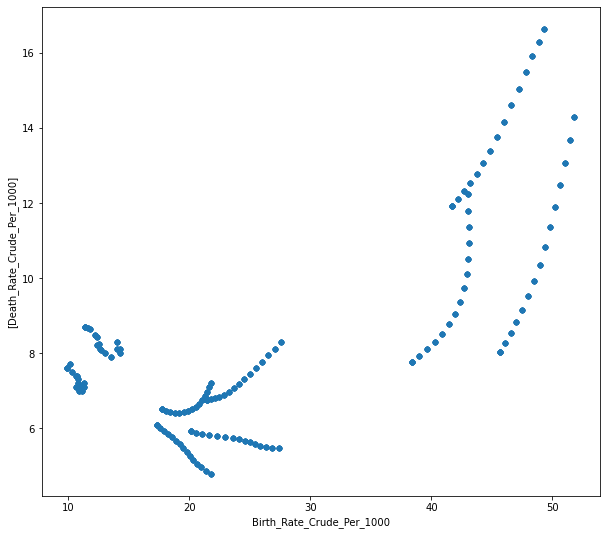

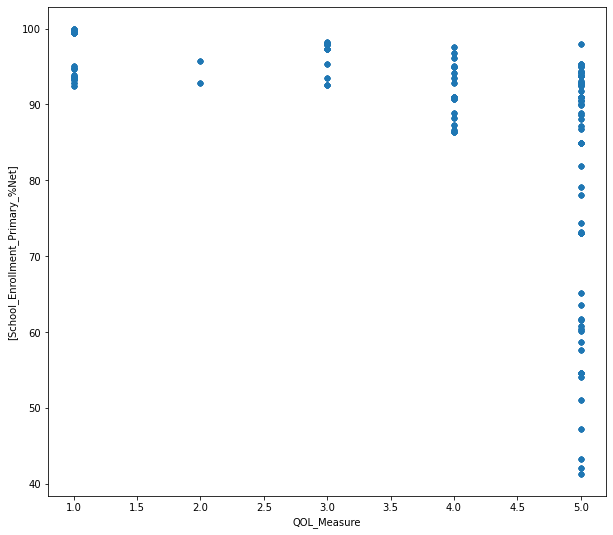

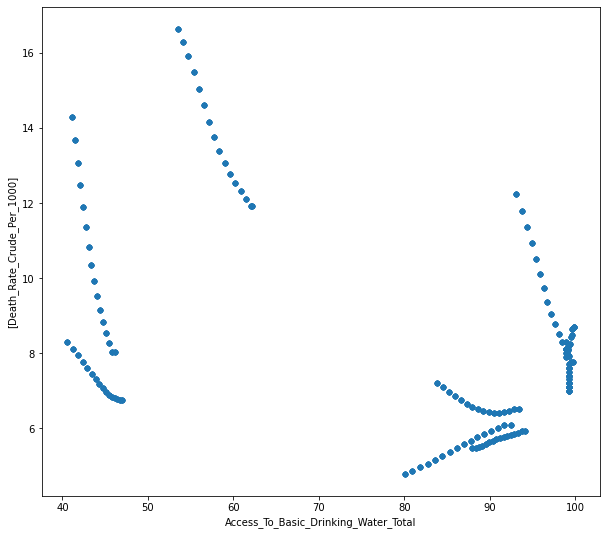

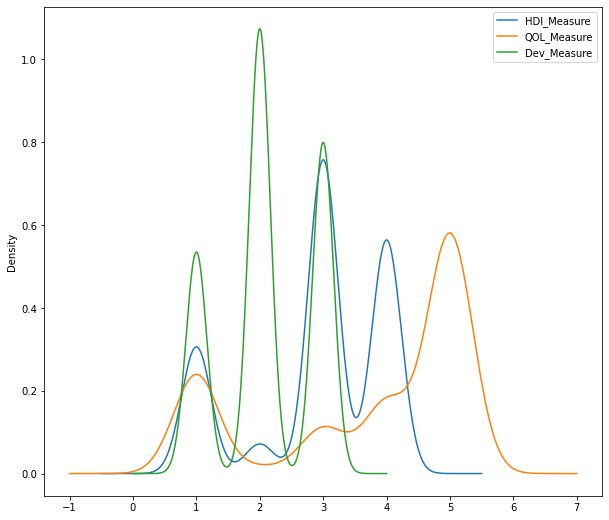

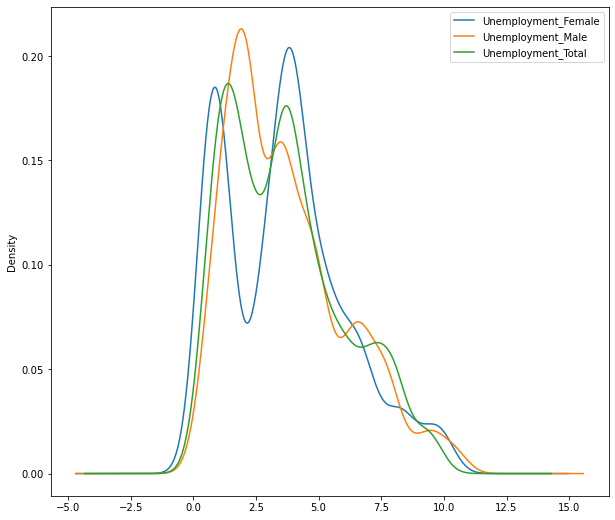

In [182]:
df.plot(x="Birth_Rate_Crude_Per_1000", y=["Death_Rate_Crude_Per_1000"], kind="scatter", figsize=(10, 9))

df.plot(x="QOL_Measure", y=["School_Enrollment_Primary_%Net"], kind="scatter", figsize=(10, 9))

df.plot(x="Access_To_Basic_Drinking_Water_Total", y=["Death_Rate_Crude_Per_1000"], kind="scatter", figsize=(10, 9))

df.plot(y=["HDI_Measure", "QOL_Measure", "Dev_Measure"], kind="density", figsize=(10, 9))

df.plot(y=["Unemployment_Female", "Unemployment_Male", "Unemployment_Total"], kind="density", figsize=(10, 9))



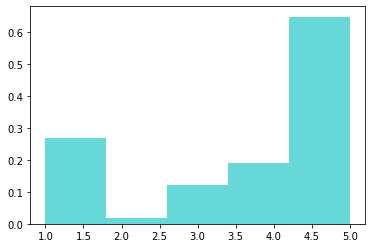

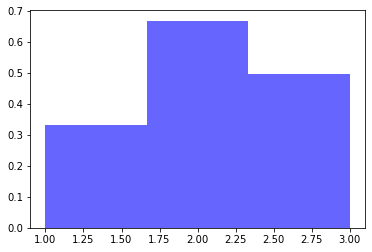

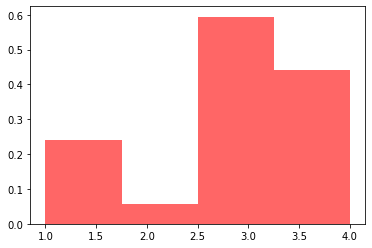

In [183]:

# df.QOL_Measure.value_counts().hist()

plt.hist(df.QOL_Measure, bins=5, density=True, alpha=0.6, color='c')
plt.show()

plt.hist(df.Dev_Measure, bins=3, density=True, alpha=0.6, color='b')
plt.show()

plt.hist(df.HDI_Measure, bins=4, density=True, alpha=0.6, color='r')
plt.show()





One Hot Encoding Events

In [184]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df =pd.DataFrame(encoder.fit_transform(df[['Disaster_Type']]).toarray())

encoder_df.columns=["Complex_Disasters","Drought","Earthquake","Epidemic","Flood","Industrial Accident","Landslide","None","Storm","Wildfire"]

# encoder_QOL = pd.DataFrame(encoder.fit_transform(df[['QOL_Measure']]).toarray())
# encoder_QOL.columns = ["QOL_Excellent", "QOL_Good", "QOL_Moderate", "QOL_Fair", "QOL_Low"]

final_df = df.join(encoder_df)
# final_df = final_df.join(encoder_QOL)
final_df.tail()


,Continent,Name,Year,Birth_Rate_Crude_Per_1000,Death_Rate_Crude_Per_1000,GNI_Per_Capita_USD,Labour_Force_Female_%,Age_First_Marriage_Male,Age_First_Marriage_Female,School_Enrollment_Primary_%Net,...,Complex_Disasters,Drought,Earthquake,Epidemic,Flood,Industrial Accident,Landslide,None,Storm,Wildfire
1733,USA,August,2020,11.4,8.7,64530,46.295513,29.2,25.6,93.669334,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1734,USA,April,2020,11.4,8.7,64530,46.295513,29.2,25.6,93.669334,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1735,USA,May,2020,11.4,8.7,64530,46.295513,29.2,25.6,93.669334,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1736,USA,June,2020,11.4,8.7,64530,46.295513,29.2,25.6,93.669334,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1737,USA,July,2020,11.4,8.7,64530,46.295513,29.2,25.6,93.669334,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Combine events for the same month

Normalise Data

In [185]:
#we need to drop string columns
final_df.drop(['Continent', 'Name', 'Year', 'Disaster_Type', 'Start_Month', 'End_Month', "Start_Year", "End_Year"], axis=1, inplace=True)

scaler = MinMaxScaler()
normalized_df = pd.DataFrame(scaler.fit_transform(final_df), columns=final_df.columns, index=final_df.index) 

normalized_df.head()


# print(normalized_df.columns)


,Birth_Rate_Crude_Per_1000,Death_Rate_Crude_Per_1000,GNI_Per_Capita_USD,Labour_Force_Female_%,Age_First_Marriage_Male,Age_First_Marriage_Female,School_Enrollment_Primary_%Net,School_Enrollment_Secondary_%Net,Total_Deaths,Total_Injuries,...,Complex_Disasters,Drought,Earthquake,Epidemic,Flood,Industrial Accident,Landslide,None,Storm,Wildfire
0,0.283039,0.203563,0.016406,0.019756,0.576923,0.601942,0.9149,0.724752,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.283039,0.203563,0.016406,0.019756,0.576923,0.601942,0.9149,0.724752,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.283039,0.203563,0.016406,0.019756,0.576923,0.601942,0.9149,0.724752,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.283039,0.203563,0.016406,0.019756,0.576923,0.601942,0.9149,0.724752,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.283039,0.203563,0.016406,0.019756,0.576923,0.601942,0.9149,0.724752,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Split X and Y values

In [186]:
# y = pd.DataFrame(normalized_df, columns=["QOL_Excellent", "QOL_Good", "QOL_Moderate", "QOL_Fair", "QOL_Low"])
y = final_df["QOL_Measure"]
x = normalized_df
# x.drop(['QOL_Measure', 'Dev_Measure', 'HDI_Measure'], axis=1, inplace=True)

display(y.head())
# df['y'] = df["a"].astype(str).astype(int)
# print(x.columns)




0    4
1    4
2    4
3    4
4    4
Name: QOL_Measure, dtype: int64

Split Data into Train and Test Sets

In [187]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, shuffle=True, stratify=y)

In [188]:
# y_test.drop(columns=y_train.columns[0], axis=1, inplace=True)
y_test.head()

347     5
1588    1
330     5
1312    5
254     5
Name: QOL_Measure, dtype: int64

In [189]:
x_train.to_csv('x_train.csv')
y_train.to_csv('y_train.csv')
x_test.to_csv('x_test.csv')
y_test.to_csv('y_test.csv')

In [190]:
reduced = normalized_df
reduced.shape
reduced.drop(reduced.iloc[:, 30:47], axis = 1, inplace = True)
reduced.drop(['Life_Exp_Birth_Male_Yr','Life_Exp_Birth_Female_Yr', 'Labour_Force_Female_%', 'GNI_Per_Capita_USD', 'ImmunizationMeasles%Children12To23Months',  'Immunization_HepB3_%OneYearOld'], axis=1, inplace=True)
reduced.head()

,Birth_Rate_Crude_Per_1000,Death_Rate_Crude_Per_1000,Age_First_Marriage_Male,Age_First_Marriage_Female,School_Enrollment_Primary_%Net,School_Enrollment_Secondary_%Net,Total_Deaths,Total_Injuries,Total_Homeless,Total_Affected,...,Total_Alcohol_Consumption_Per_Capita,Number_Under-five_Deaths,Hospital_Beds_Per_1000ppl,Adults_Newly_Infected_With_HIV,Adults_And_Children_Living_With_HIV,Life_Exp_Birth_Total_Yr,Population_Growth_%,Access_To_Basic_Drinking_Water_Total,Access_To_Basic_Drinking_Water_Urban,Access_To_Basic_Sanitation_Total
0,0.283039,0.203563,0.576923,0.601942,0.9149,0.724752,0.0,0.0,0.0,0.0,...,0.418274,0.061449,0.275862,0.0,0.0051,0.500391,0.403001,0.728279,0.857338,0.354099
1,0.283039,0.203563,0.576923,0.601942,0.9149,0.724752,0.0,0.0,0.0,0.0,...,0.418274,0.061449,0.275862,0.0,0.0051,0.500391,0.403001,0.728279,0.857338,0.354099
2,0.283039,0.203563,0.576923,0.601942,0.9149,0.724752,0.0,0.0,0.0,0.0,...,0.418274,0.061449,0.275862,0.0,0.0051,0.500391,0.403001,0.728279,0.857338,0.354099
3,0.283039,0.203563,0.576923,0.601942,0.9149,0.724752,0.0,0.0,0.0,0.0,...,0.418274,0.061449,0.275862,0.0,0.0051,0.500391,0.403001,0.728279,0.857338,0.354099
4,0.283039,0.203563,0.576923,0.601942,0.9149,0.724752,0.0,0.0,0.0,0.0,...,0.418274,0.061449,0.275862,0.0,0.0051,0.500391,0.403001,0.728279,0.857338,0.354099


In [191]:
x_reduced = reduced
# x_reduced.drop('QOL_Measure')
y_reduced = final_df["QOL_Measure"]


In [192]:
x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = train_test_split(
    x_reduced, y_reduced, test_size=0.3, shuffle=True, stratify=y)

In [193]:
x_train_reduced.to_csv('x_train_reduced.csv')
y_train_reduced.to_csv('y_train_reduced.csv')
x_test_reduced.to_csv('x_test_reduced.csv')
y_test_reduced.to_csv('y_test_reduced.csv')